In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle as pkl

from os.path import join as oj
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from torch.utils.data import Subset
sns.set()

In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as utils
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score

import csv
import numpy as np
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from shutil import copyfile
from os.path import join as oj
from PIL import Image
from tqdm import tqdm
from skimage.color import rgb2gray

    

In [3]:
save_path = "../../results_for_export"

In [4]:
from torch import nn

In [5]:
device = torch.device("cuda")

In [6]:
import torchvision.models as models

model = models.vgg16(pretrained=True).to(device)
model.classifier[-1] = nn.Linear(4096, 2)
model.load_state_dict(torch.load('../models/cancer_prim.pt'))
model = model.to(device)

In [8]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

In [9]:
data_root  = "../../../../datasets/ISIC"
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
img_dataset = datasets.ImageFolder(data_root,transform=data_transform)
num_total = len(img_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(img_dataset, [num_train, num_test, num_val])

In [10]:
datasets = {'train' : train_dataset, 'test':test_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test','val']}

In [11]:

not_cancer_ratio = np.asarray(train_dataset.dataset.targets).mean() 
cancer_ratio = 1- not_cancer_ratio
cancer_weight = 1/cancer_ratio
not_cancer_weight = 1/ not_cancer_ratio
weights = np.asarray([cancer_weight, not_cancer_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

In [12]:
def eval_model_on(dataset):
    val_filtered_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
    model.eval()
    y = []
    y_hat = []
    has_line = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels in tqdm_notebook(val_filtered_dataloader):
            y_hat.append((1-labels).cpu().numpy())
            y.append(torch.nn.Softmax()( model(inputs.cuda()))[:,0].detach().cpu().numpy())
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat
def get_auc_curve(y, y_hat):
    x_vals= np.linspace(0, 1, num = 1000)
    specificity  = np.empty((1000))
    sensitivity  = np.empty((1000))
    for i in range(1000):
        specificity[i] = (y[np.where(y_hat == 0)] <x_vals[i]).mean()
        sensitivity[i] = (y > x_vals[i])[np.where(y_hat == 1)].mean()
    return sensitivity, specificity


# Test model on all

In [13]:
sens_spec_dic = {}

In [14]:
from tqdm import tqdm_notebook

In [15]:
y_all, y_hat_all = eval_model_on(val_dataset)
sens_spec_dic["All"]=  get_auc_curve(y_all, y_hat_all)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

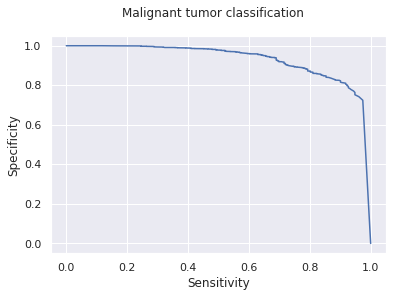

In [18]:
fig, ax = plt.subplots()
ax.plot(sens_spec_dic["All"][0], sens_spec_dic["All"][1])
ax.set_ylabel("Specificity");
ax.set_xlabel("Sensitivity");
fig.suptitle("Malignant tumor classification")
fig.savefig(oj(save_path, "Vanilla_skincancer"))


# Righto, now we try the same while excluding all benign with patches

In [37]:
img_list =img_dataset.imgs
file_names = [x[0] for x in img_list]
start_patch_ind = file_names.index('../../../datasets/ISIC/not_cancer/ISIC_0000557.jpg')
end_patch_ind = file_names.index('../../../datasets/ISIC/not_cancer/ISIC_0009867.jpg')
patch_indice = np.arange(start_patch_ind,end_patch_ind+1)
start_ruler_ind = file_names.index('../../../datasets/ISIC/cancer/ISIC_0012099.jpg')
end_ruler_ind = file_names.index('../../../datasets/ISIC/cancer/ISIC_0014559.jpg')
ruler_indice = np.arange(start_ruler_ind,end_ruler_ind+1)
filter_idx = np.concatenate((patch_indice, ruler_indice))
val_filtered_only_bad = Subset(img_dataset, list(filter(lambda x: x in filter_idx, val_dataset.indices)) )
val_filtered_all = Subset(img_dataset, list(filter(lambda x: x not in filter_idx, val_dataset.indices)) )
val_filtered_ruler = Subset(img_dataset, list(filter(lambda x: x not in ruler_indice, val_dataset.indices)) )
val_filtered_patches = Subset(img_dataset, list(filter(lambda x: x not in patch_indice, val_dataset.indices)) )

In [20]:
y_all_filtered, y_hat_filtered = eval_model_on(val_filtered_all)
sens_spec_dic["Filtered (All)"]= get_auc_curve(y_all_filtered, y_hat_filtered)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [21]:
y_ruler, y_hat_ruler = eval_model_on(val_filtered_ruler)
sens_spec_dic["Filtered (Ruler)"]= get_auc_curve(y_ruler, y_hat_ruler)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

In [22]:
y_patches, y_hat_patches = eval_model_on(val_filtered_patches)
sens_spec_dic["Filtered (Patches)"]=get_auc_curve(y_patches, y_hat_patches)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipyker

In [44]:
auc_dic = {'All': 0.9382681913052785,
 'Filtered (All)': 0.8849866221041194,
 'Filtered (Ruler)': 0.9378590359998331,
 'Filtered (Patches)': 0.885734336588931}

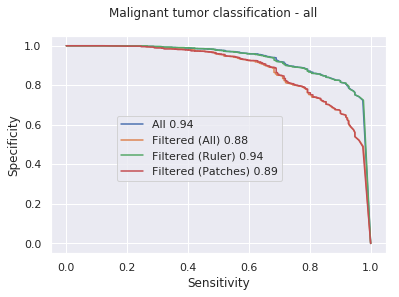

In [48]:
fig, ax = plt.subplots()
for key in sens_spec_dic.keys():
    ax.plot(sens_spec_dic[key][0], sens_spec_dic[key][1], label = key + " "+ "{:2.2f}".format(auc_dic[key]))
ax.set_ylabel("Specificity");
ax.set_xlabel("Sensitivity");
fig.legend(loc=10)
fig.suptitle("Malignant tumor classification - all")
fig.savefig(oj(save_path, "Vanilla_skincancer_all"))
